# Evaluating Tool-Use Errors with Limbic

This notebook evaluates how agents use tools, using the Limbic evaluator.  
It runs models on a compact dataset of tool-use tasks, checks their outputs against ground truth,  
and analyzes error patterns across categories (incorrect tool, incorrect parameter names, incorrect parameter values).  


## Setup  

We install required libraries and set up API keys for running models.  
- `together` for calling Kimi K2 and Qwen  
- Standard Python libraries for JSON handling and plotting

In [ ]:
!pip install --upgrade together

In [ ]:
import os
import json
import time
from typing import Dict, List, Any, Optional
import requests
import pandas as pd
from datetime import datetime
import random
from collections import defaultdict

import openai
from together import Together

In [ ]:
os.environ['TOGETHER_API_KEY'] = "your_togetherai_api_key"

## Dataset

We use a compact dataset of 15 evaluation cases (`tools_evaluations.jsonl`).  
Each record specifies:  
- A user request in natural language  
- A set of available tool schemas  
- A ground-truth tool call  

The dataset spans test types such as simple correct calls, optional parameters, structured data, and ambiguous mappings.  

In [ ]:
# Load test data from the new file
with open("tools_evaluations.jsonl") as f:
    data = [json.loads(line.strip()) for line in f]

print(f"Loaded {len(data)} test examples")

# Check data structure
print("\nFirst entry structure:")
print("Keys:", data[0].keys())
print("\nGenerated Content structure:")
print(json.dumps(data[0]["generated_data"], indent=2))
print("\nAvailable Tools structure:")
print(json.dumps(data[0]["available_tools"], indent=2))

Loaded 15 test examples

First entry structure:
Keys: dict_keys(['original_tool', 'generated_data', 'timestamp', 'ground_truth_tool_call', 'available_tools', 'mixture_type'])

Generated Content structure:
{
  "tool_parameters": {
    "location": "San Francisco",
    "unit": "fahrenheit"
  },
  "user_prompt": "What's the weather like in San Francisco today? I need to know if I should bring a jacket.",
  "system_prompt": "The user is planning their day in San Francisco and needs current weather information to make clothing decisions."
}

Available Tools structure:
[
  {
    "name": "get_weather",
    "description": "Get current weather information for a specified location\n\nReturns temperature, conditions, and forecast\n\nParameters:\n- location: City name or coordinates (required)\n- unit: Temperature unit - 'celsius' or 'fahrenheit' (optional, default: celsius)",
    "inputSchema": {
      "type": "object",
      "properties": {
        "location": {
          "type": "string",
      

## Formatting tool calls for TogetherAI

In [ ]:
def format_tool(tool):
    """Format tool to match Together's expected schema"""
    schema = tool.get("inputSchema", tool.get("parameters", {}))

    return {
        "type": "function",
        "function": {
            "name": tool.get("name"),
            "description": tool.get("description", ""),
            "parameters": schema  # This becomes 'parameters' for the API
        }
    }

def call_together_api(
    user_prompt: str,
    model: str,
    system_prompt: Optional[str] = None,
    tools: Optional[list] = None,
    temperature: float = 0.6
) -> Dict[str, Any]:
    """Call Together API with support for different models and tools"""
    client = Together()

    # Build messages
    messages = []
    if system_prompt:
        messages.append({"role": "system", "content": system_prompt})
    messages.append({"role": "user", "content": user_prompt})

    # Build API parameters
    params = {
        "model": model,
        "messages": messages,
        "temperature": temperature
    }

    # Add tools if provided
    if tools:
        formatted_tools = [format_tool(tool) for tool in tools]
        params["tools"] = formatted_tools
        params["tool_choice"] = "auto"

    try:
        # Make API call
        response = client.chat.completions.create(**params)

        # Handle regular response
        tool_calls = []
        if hasattr(response.choices[0].message, 'tool_calls') and response.choices[0].message.tool_calls:
            for tool_call in response.choices[0].message.tool_calls:
                tool_calls.append({
                    "type": "tool_use",
                    "id": tool_call.id,
                    "name": tool_call.function.name,
                    "input": json.loads(tool_call.function.arguments)
                })

        return {
            "success": True,
            "messages": [
                {"role": "user", "content": user_prompt},
                {"role": "assistant", "content": tool_calls if tool_calls else None}
            ]
        }
    except Exception as e:
        print(f"Error calling model: {str(e)[:100]}")
        return {
            "success": False,
            "error": str(e)
        }

## Evaluating with Limbic

Limbic inspects each tool call and assigns one of four labels:  
- correct  
- incorrect_tool  
- incorrect_parameter_names  
- incorrect_parameter_values  

This gives us structured judgments instead of raw pass/fail results.  

In [ ]:
# Limbic Evaluation

def get_tool_call_eval(messages: List[dict], available_tools: List[dict]) -> Dict[str, Any]:
    """Limbic API evaluation function"""
    payload = {
        "messages": messages,
        "available_tools": available_tools
    }

    url = "https://quotient-ai--tool-call-evaluator-7b-api-v0-fastapi-app.modal.run/api/v1/detections/tool-use"
    try:
        response = requests.post(url, json=payload, timeout=120)
        if response.status_code == 200:
            result = response.json()
            return {
                "success": True,
                "status_code": response.status_code,
                "score": result["score"],
                "reasoning": result["reasoning"],
            }
        else:
            return {
                "success": False,
                "status_code": response.status_code,
                "error": response.text,
            }
    except Exception as e:
        return {
            "success": False,
            "error": str(e),
        }

## Run Models

We run two models (Kimi K2, Qwen) on each test case.  
Their outputs are captured as tool calls, which are then passed into Limbic for evaluation.  

In [ ]:
# Initialize models configuration
models = [
    {
        "name": "Kimi K2",
        "model": "moonshotai/Kimi-K2-Instruct"
    },
    {
        "name": "Qwen",
        "model": "Qwen/Qwen3-235B-A22B-Instruct-2507-tput"
    }
]

# Initialize score tracking
score_categories = [
    "correct",
    "incorrect_tool",
    "incorrect_parameter_names",
    "incorrect_parameter_values"
]

scores = {
    model["name"]: {
        category: 0 for category in score_categories
    } for model in models
}

# Store detailed results
detailed_results = []

# Select random subset of 100 examples
random_subset = random.sample(data, len(data))
total_examples = len(random_subset)

# Process examples and evaluate with both models
print(f"Processing {total_examples} random examples...")
print("-" * 50)

for i, entry in enumerate(random_subset, 1):
    print(f"\nExample {i}:")
    user_prompt = entry["generated_data"]["user_prompt"]
    test_type = entry.get("mixture_type", "unknown")
    print(f"User Prompt: {user_prompt[:100]}...")

    total_examples += 1

    for model_config in models:
        print(f"\n{model_config['name']} Response:")
        try:
            # Call model
            result = call_together_api(
                user_prompt=user_prompt,
                model=model_config["model"],
                tools=entry["available_tools"]
            )

            tool_calls = result["messages"][1]["content"]

            # Handle null responses properly
            if tool_calls is None:
                print("null")
            else:
                print(json.dumps(tool_calls, indent=2))

            # Evaluate with Limbic
            limbic_result = get_tool_call_eval(result["messages"], entry["available_tools"])

            print(f"\nLimbic Evaluation:")
            if limbic_result["success"]:
                print(f"Score: {limbic_result['score']}")
                print(f"Reasoning: {limbic_result['reasoning']}")

                # Track score
                scores[model_config["name"]][limbic_result["score"]] += 1

                # Save detailed result INCLUDING NULL RESPONSES
                detailed_results.append({
                    'example_id': i,
                    'test_type': test_type,
                    'model': model_config["name"],
                    'user_prompt': user_prompt,
                    'tool_called': tool_calls[0]["name"] if tool_calls else "NO_TOOL_CALLED",
                    'tool_params': tool_calls[0]["input"] if tool_calls else None,
                    'limbic_score': limbic_result["score"],
                    'limbic_reasoning': limbic_result.get("reasoning", []),
                    'was_null_response': tool_calls is None,  # Track null responses
                    'ground_truth': entry.get("ground_truth_tool_call")
                })

            else:
                print(f"Error: {limbic_result.get('error', 'Unknown error')}")

        except Exception as e:
            print(f"Error: {str(e)}")

    print("-" * 50)
    time.sleep(1)  # Rate limiting

Processing 15 random examples...
--------------------------------------------------

Example 1:
User Prompt: What's the sentiment of this review: 'This product exceeded my expectations! The quality is amazing ...

Kimi K2 Response:
[
  {
    "type": "tool_use",
    "id": "call_iafjd9d1zi0sjgo0j0b4ospn",
    "name": "analyze_sentiment",
    "input": {
      "text": "This product exceeded my expectations! The quality is amazing and shipping was fast. Highly recommend!"
    }
  }
]

Limbic Evaluation:
Score: correct
Reasoning: []

Qwen Response:
[
  {
    "type": "tool_use",
    "id": "call_3jhv773jls7u5c772zqhz2ys",
    "name": "analyze_sentiment",
    "input": {
      "text": "This product exceeded my expectations! The quality is amazing and shipping was fast. Highly recommend!"
    }
  }
]

Limbic Evaluation:
Score: correct
Reasoning: []
--------------------------------------------------

Example 2:
User Prompt: I need to book a flight for 2 people from New York JFK to Los Angeles on D

## Results Aggregation
We aggregate Limbic’s outputs into error distributions by model and test type.  
The visualization highlights where models succeed, and which error categories dominate.  


In [ ]:
# Print aggregated results
print("\nAggregated Results:")
print("-" * 50)
print(f"Total examples processed: {total_examples}\n")

for model_name, model_scores in scores.items():
    print(f"\n{model_name} Results:")
    print("-" * 20)
    for category, count in model_scores.items():
        percentage = (count / total_examples) * 100
        print(f"{category}: {count} ({percentage:.1f}%)")

# Create a summary
print("\nScore Distribution:")
print("-" * 50)
for model_name, model_scores in scores.items():
    print(f"\n{model_name}:")
    max_bar_length = 40
    for category, count in model_scores.items():
        percentage = (count / total_examples) * 100
        bar_length = int((count / total_examples) * max_bar_length)
        bar = "█" * bar_length
        print(f"{category:25} [{bar:<40}] {percentage:.1f}%")


Aggregated Results:
--------------------------------------------------
Total examples processed: 30


Kimi K2 Results:
--------------------
correct: 11 (36.7%)
incorrect_tool: 2 (6.7%)
incorrect_parameter_names: 2 (6.7%)
incorrect_parameter_values: 0 (0.0%)

Qwen Results:
--------------------
correct: 14 (46.7%)
incorrect_tool: 0 (0.0%)
incorrect_parameter_names: 1 (3.3%)
incorrect_parameter_values: 0 (0.0%)

Score Distribution:
--------------------------------------------------

Kimi K2:
correct                   [██████████████                          ] 36.7%
incorrect_tool            [██                                      ] 6.7%
incorrect_parameter_names [██                                      ] 6.7%
incorrect_parameter_values [                                        ] 0.0%

Qwen:
correct                   [██████████████████                      ] 46.7%
incorrect_tool            [                                        ] 0.0%
incorrect_parameter_names [█                       

# Visualize the results

From the results, we can see:  
- Accuracy differences between models  
- Most common error categories  
- Hard test types (structured data, optional parameters)  

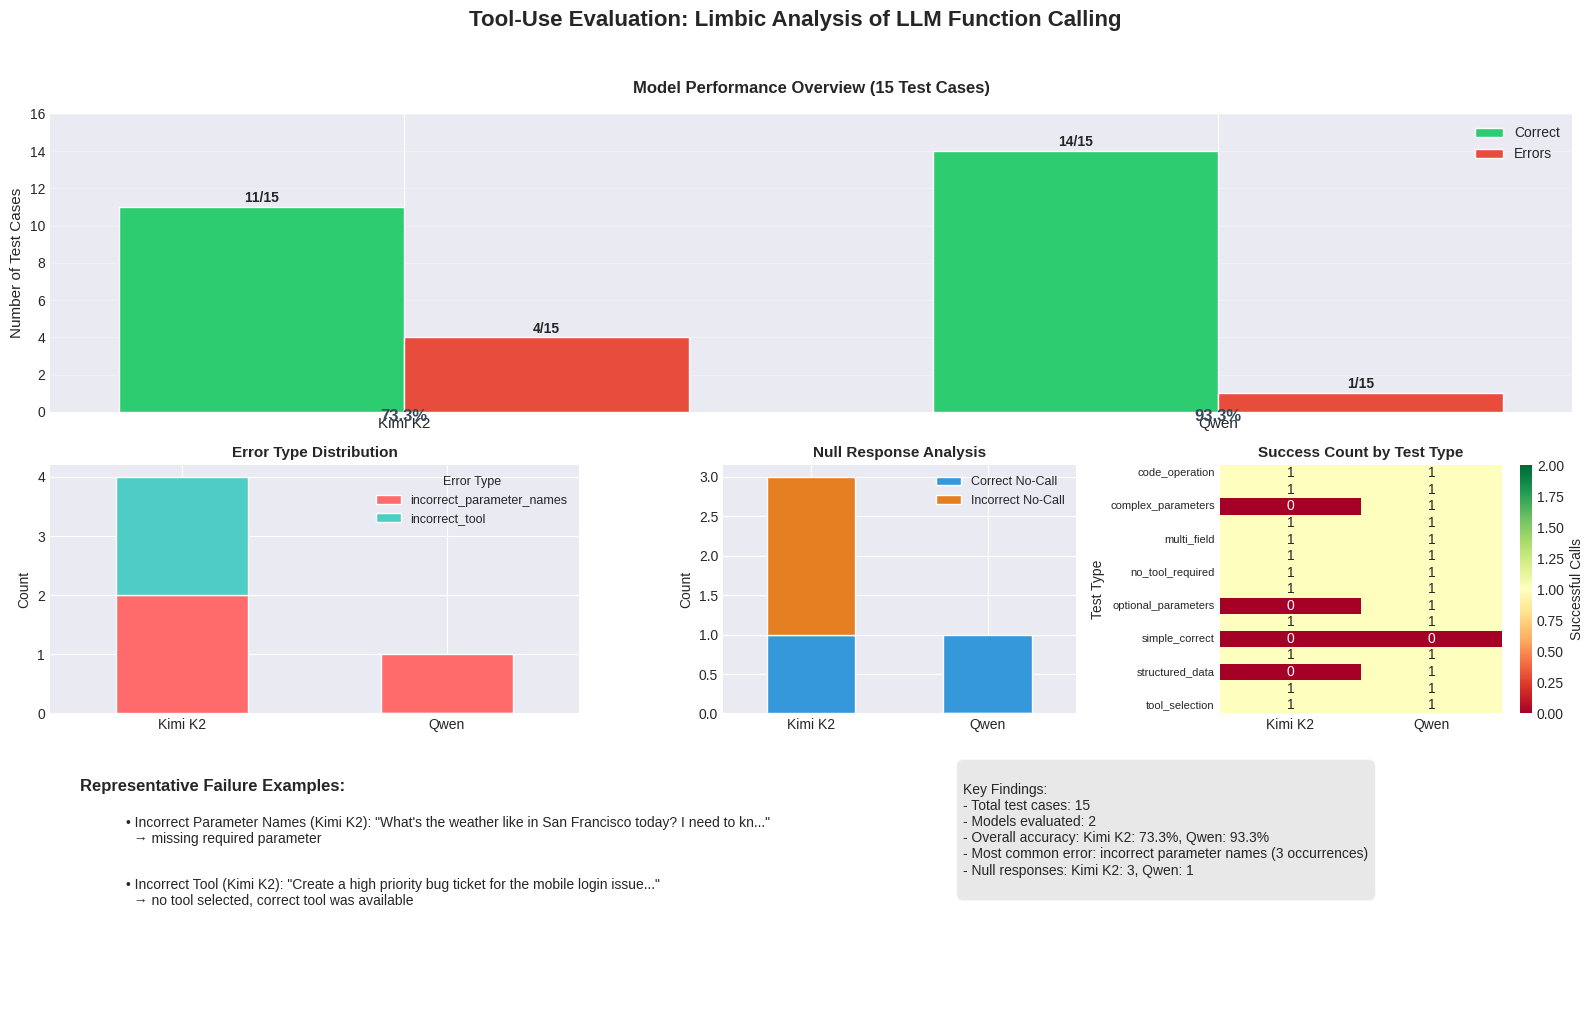

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from datetime import datetime

# Convert to DataFrame
results_df = pd.DataFrame(detailed_results)

# results_df.to_csv(f"evaluation_results_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv", index=False)

# Set style for professional appearance
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Create figure with better layout
fig = plt.figure(figsize=(16, 10))
fig.suptitle('Tool-Use Evaluation: Limbic Analysis of LLM Function Calling',
             fontsize=16, fontweight='bold', y=1.02)

# Create grid with specific sizing
gs = fig.add_gridspec(3, 3, height_ratios=[1.2, 1, 1], width_ratios=[1.5, 1, 1])

# 1. MAIN CHART: Overall Performance Comparison
ax1 = fig.add_subplot(gs[0, :])

# Calculate metrics properly
models_data = []
for model in results_df['model'].unique():
    model_df = results_df[results_df['model'] == model]
    total = len(model_df)
    correct = (model_df['limbic_score'] == 'correct').sum()

    models_data.append({
        'Model': model,
        'Correct': correct,
        'Errors': total - correct,
        'Total': total,
        'Accuracy': (correct / total * 100)
    })

perf_df = pd.DataFrame(models_data)

# Create grouped bar chart
x = np.arange(len(perf_df))
width = 0.35

bars1 = ax1.bar(x - width/2, perf_df['Correct'], width, label='Correct', color='#2ECC71')
bars2 = ax1.bar(x + width/2, perf_df['Errors'], width, label='Errors', color='#E74C3C')

# Add value labels
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.1,
             f'{int(height)}/15', ha='center', va='bottom', fontweight='bold')

for bar in bars2:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.1,
             f'{int(height)}/15', ha='center', va='bottom', fontweight='bold')

# Add accuracy percentages
for i, (idx, row) in enumerate(perf_df.iterrows()):
    ax1.text(i, -0.5, f'{row["Accuracy"]:.1f}%', ha='center',
             fontweight='bold', fontsize=12, color='#34495E')

ax1.set_ylabel('Number of Test Cases', fontsize=11)
ax1.set_title('Model Performance Overview (15 Test Cases)', fontsize=12, fontweight='bold', pad=15)
ax1.set_xticks(x)
ax1.set_xticklabels(perf_df['Model'], fontsize=11)
ax1.legend(loc='upper right', fontsize=10)
ax1.set_ylim([0, 16])
ax1.grid(axis='y', alpha=0.3)

# 2. Error Type Distribution
ax2 = fig.add_subplot(gs[1, 0])

# Get error distribution
error_types = results_df[results_df['limbic_score'] != 'correct'].groupby(
    ['model', 'limbic_score']).size().unstack(fill_value=0)

if not error_types.empty:
    error_types.plot(kind='bar', stacked=True, ax=ax2,
                     color=['#FF6B6B', '#4ECDC4', '#95A5A6'])
    ax2.set_title('Error Type Distribution', fontsize=11, fontweight='bold')
    ax2.set_xlabel('')
    ax2.set_ylabel('Count', fontsize=10)
    ax2.legend(title='Error Type', fontsize=9, title_fontsize=9)
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0)
else:
    ax2.text(0.5, 0.5, 'No errors found', ha='center', va='center')

# 3. Null Response Analysis
ax3 = fig.add_subplot(gs[1, 1])

null_data = []
for model in results_df['model'].unique():
    model_df = results_df[results_df['model'] == model]
    null_count = model_df['was_null_response'].sum()
    null_correct = ((model_df['was_null_response'] == True) &
                   (model_df['limbic_score'] == 'correct')).sum()
    null_incorrect = null_count - null_correct

    null_data.append({
        'Model': model,
        'Correct No-Call': null_correct,
        'Incorrect No-Call': null_incorrect
    })

null_df = pd.DataFrame(null_data)
null_df.set_index('Model')[['Correct No-Call', 'Incorrect No-Call']].plot(
    kind='bar', stacked=True, ax=ax3, color=['#3498DB', '#E67E22'])
ax3.set_title('Null Response Analysis', fontsize=11, fontweight='bold')
ax3.set_xlabel('')
ax3.set_ylabel('Count', fontsize=10)
ax3.legend(fontsize=9)
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=0)

# 4. Test Type Performance
ax4 = fig.add_subplot(gs[1, 2])

# Calculate success rate by test type
test_perf = results_df.pivot_table(
    index='test_type',
    columns='model',
    values='limbic_score',
    aggfunc=lambda x: (x == 'correct').sum()
).fillna(0)

# Only show test types with at least one evaluation
test_counts = results_df.groupby('test_type').size()
test_perf['Total Tests'] = test_counts
test_perf = test_perf[test_perf['Total Tests'] > 0]

# Show as heatmap with counts (not percentages)
sns.heatmap(test_perf[results_df['model'].unique()],
            annot=True, fmt='.0f', cmap='RdYlGn',
            ax=ax4, vmin=0, vmax=2,
            cbar_kws={'label': 'Successful Calls'})
ax4.set_title('Success Count by Test Type', fontsize=11, fontweight='bold')
ax4.set_xlabel('')
ax4.set_ylabel('Test Type', fontsize=10)
ax4.set_yticklabels(ax4.get_yticklabels(), rotation=0, fontsize=8)

# 5. Specific Failure Examples
ax5 = fig.add_subplot(gs[2, :])
ax5.axis('off')

# Collect interesting failure examples
failure_examples = []
errors = results_df[results_df['limbic_score'] != 'correct']

# Group by error type for diversity
for error_type in errors['limbic_score'].unique():
    example = errors[errors['limbic_score'] == error_type].iloc[0]
    failure_examples.append({
        'Type': error_type.replace('_', ' ').title(),
        'Model': example['model'],
        'Test': example['test_type'],
        'Prompt': example['user_prompt'][:60] + '...',
        'Issue': example['limbic_reasoning'][0] if example['limbic_reasoning'] else 'No reason provided'
    })

# Create table of examples
if failure_examples:
    ax5.text(0.02, 0.9, 'Representative Failure Examples:',
             fontsize=12, fontweight='bold')

    y_pos = 0.7
    for i, ex in enumerate(failure_examples[:3]):  # Show top 3
        text = f"• {ex['Type']} ({ex['Model']}): \"{ex['Prompt']}\"\n  → {ex['Issue']}"
        ax5.text(0.05, y_pos - i*0.25, text, fontsize=10, wrap=True)

# Add summary statistics box
summary_text = f"""
Key Findings:
- Total test cases: 15
- Models evaluated: {results_df['model'].nunique()}
- Overall accuracy: Kimi K2: {perf_df[perf_df['Model']=='Kimi K2']['Accuracy'].values[0]:.1f}%, Qwen: {perf_df[perf_df['Model']=='Qwen']['Accuracy'].values[0]:.1f}%
- Most common error: {errors['limbic_score'].mode()[0].replace('_', ' ')} ({errors['limbic_score'].value_counts().iloc[0]} occurrences)
- Null responses: Kimi K2: {results_df[(results_df['model']=='Kimi K2') & (results_df['was_null_response']==True)].shape[0]}, Qwen: {results_df[(results_df['model']=='Qwen') & (results_df['was_null_response']==True)].shape[0]}
"""

ax5.text(0.6, 0.5, summary_text, fontsize=10,
         bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgray", alpha=0.5))

plt.tight_layout()
plt.savefig(f'blog_evaluation_visualization_{datetime.now().strftime("%Y%m%d_%H%M%S")}.png',
            dpi=150, bbox_inches='tight')
plt.show()

## Generate insights

In [ ]:
# Calculate key metrics
total_evaluations = len(results_df)
unique_examples = results_df['example_id'].nunique()

print(f"\nDataset Overview:")
print(f"- Examples tested: {unique_examples}")
print(f"- Models evaluated: {results_df['model'].nunique()}")
print(f"- Total evaluations: {total_evaluations}")

print(f"\nPerformance Summary:")
for model in results_df['model'].unique():
    model_df = results_df[results_df['model'] == model]
    accuracy = (model_df['limbic_score'] == 'correct').mean() * 100
    null_rate = model_df['was_null_response'].mean() * 100
    print(f"\n{model}:")
    print(f"  - Accuracy: {accuracy:.1f}%")
    print(f"  - Null response rate: {null_rate:.1f}%")

    # Most common error
    errors = model_df[model_df['limbic_score'] != 'correct']['limbic_score']
    if len(errors) > 0:
        print(f"  - Most common error: {errors.mode()[0]}")

print(f"\nKey Findings:")
# Null response insight
null_responses = results_df[results_df['was_null_response'] == True]
if len(null_responses) > 0:
    print(f"- {len(null_responses)} cases where models didn't call any tool")
    null_correct = null_responses[null_responses['limbic_score'] == 'correct']
    print(f"  - {len(null_correct)} were correctly identified as not needing tools")
    null_wrong = null_responses[null_responses['limbic_score'] != 'correct']
    print(f"  - {len(null_wrong)} should have called a tool but didn't")

# Error patterns
print(f"\nError Patterns:")
error_dist = results_df[results_df['limbic_score'] != 'correct']['limbic_score'].value_counts()
for error_type, count in error_dist.items():
    examples = results_df[results_df['limbic_score'] == error_type]['test_type'].value_counts().head(1)
    if len(examples) > 0:
        print(f"- {error_type}: {count} occurrences, most common in '{examples.index[0]}' tests")


Dataset Overview:
- Examples tested: 15
- Models evaluated: 2
- Total evaluations: 30

Performance Summary:

Kimi K2:
  - Accuracy: 73.3%
  - Null response rate: 20.0%
  - Most common error: incorrect_parameter_names

Qwen:
  - Accuracy: 93.3%
  - Null response rate: 6.7%
  - Most common error: incorrect_parameter_names

Key Findings:
- 4 cases where models didn't call any tool
  - 2 were correctly identified as not needing tools
  - 2 should have called a tool but didn't

Error Patterns:
- incorrect_parameter_names: 3 occurrences, most common in 'simple_correct' tests
- incorrect_tool: 2 occurrences, most common in 'structured_data' tests


## Detailed analysis of failure cases

In [ ]:
# Analyze failure patterns in detail
import pandas as pd

# 1. Find examples that fail in Kimi but work in Qwen
print("-"*50)
print("FAILURES IN KIMI K2 BUT SUCCESS IN QWEN:")
print("-"*50)

# Group by example_id to compare models
for example_id in results_df['example_id'].unique():
    example_data = results_df[results_df['example_id'] == example_id]

    kimi_result = example_data[example_data['model'] == 'Kimi K2'].iloc[0]
    qwen_result = example_data[example_data['model'] == 'Qwen'].iloc[0]

    # Kimi fails, Qwen succeeds
    if kimi_result['limbic_score'] != 'correct' and qwen_result['limbic_score'] == 'correct':
        print(f"\nExample {example_id} ({kimi_result['test_type']}):")
        print(f"Prompt: {kimi_result['user_prompt']}...")
        print(f"Kimi K2: {kimi_result['limbic_score']} - {kimi_result['limbic_reasoning']}")
        print(f"  Tool called: {kimi_result['tool_called']}")
        print(f"Qwen: SUCCESS")
        print(f"  Tool called: {qwen_result['tool_called']}")

# 2. Find examples that fail in both
print("\n" + "-"*50)
print("FAILURES IN BOTH MODELS:")
print("-"*50)

for example_id in results_df['example_id'].unique():
    example_data = results_df[results_df['example_id'] == example_id]

    kimi_result = example_data[example_data['model'] == 'Kimi K2'].iloc[0]
    qwen_result = example_data[example_data['model'] == 'Qwen'].iloc[0]

    # Both fail
    if kimi_result['limbic_score'] != 'correct' and qwen_result['limbic_score'] != 'correct':
        print(f"\nExample {example_id} ({kimi_result['test_type']}):")
        print(f"Prompt: {kimi_result['user_prompt']}...")
        print(f"Kimi K2: {kimi_result['limbic_score']} - {kimi_result['limbic_reasoning']}")
        print(f"Qwen: {qwen_result['limbic_score']} - {qwen_result['limbic_reasoning']}")

# 3. Analyze null response patterns
print("\n" + "-"*50)
print("NULL RESPONSE ANALYSIS:")
print("-"*50)

null_responses = results_df[results_df['was_null_response'] == True]
if len(null_responses) > 0:
    for _, row in null_responses.iterrows():
        print(f"\nModel: {row['model']}")
        print(f"Test type: {row['test_type']}")
        print(f"Prompt: {row['user_prompt']}...")
        print(f"Limbic score: {row['limbic_score']}")
        print(f"Reasoning: {row['limbic_reasoning']}")

        # Check if this was correct or not
        if row['limbic_score'] == 'correct':
            print("✓ Correctly identified no tool needed")
        else:
            print("✗ Should have called a tool")

# 4. Statistical summary
print("\n" + "-"*50)
print("STATISTICAL SUMMARY:")
print("-"*50)

# Error type distribution
error_summary = results_df[results_df['limbic_score'] != 'correct'].groupby(['limbic_score', 'model']).size().unstack(fill_value=0)
print("\nError Distribution by Model:")
print(error_summary)

# Test types with highest failure rates
failure_by_type = results_df.groupby('test_type')['limbic_score'].apply(lambda x: (x != 'correct').mean() * 100).sort_values(ascending=False)
print("\nTest Types by Failure Rate:")
for test_type, failure_rate in failure_by_type.items():
    if failure_rate > 0:
        print(f"  {test_type}: {failure_rate:.1f}% failure rate")

        # Show which models fail on this test
        test_results = results_df[results_df['test_type'] == test_type]
        for model in test_results['model'].unique():
            model_result = test_results[test_results['model'] == model].iloc[0]
            if model_result['limbic_score'] != 'correct':
                print(f"    - {model}: {model_result['limbic_score']}")

# 5. Specific interesting patterns
print("\n" + "-"*50)
print("INTERESTING PATTERNS:")
print("-"*50)

# Find parameter name errors
param_errors = results_df[results_df['limbic_score'] == 'incorrect_parameter_names']
if len(param_errors) > 0:
    print("\nParameter Name Errors:")
    for _, row in param_errors.iterrows():
        print(f"  {row['model']} on {row['test_type']}: {row['limbic_reasoning']}")

# Find tool selection errors
tool_errors = results_df[results_df['limbic_score'] == 'incorrect_tool']
if len(tool_errors) > 0:
    print("\nTool Selection Errors:")
    for _, row in tool_errors.iterrows():
        print(f"  {row['model']} on {row['test_type']}: Called {row['tool_called']}")
        print(f"    Reason: {row['limbic_reasoning']}")

--------------------------------------------------
FAILURES IN KIMI K2 BUT SUCCESS IN QWEN:
--------------------------------------------------

Example 6 (structured_data):
Prompt: Create a high priority bug ticket for the mobile login issue that users are reporting on iOS. Assign it to the dev team....
Kimi K2: incorrect_tool - ['no tool selected, correct tool was available']
  Tool called: NO_TOOL_CALLED
Qwen: SUCCESS
  Tool called: jira_create_issue

Example 12 (optional_parameters):
Prompt: Find the project proposal email that John from the client company sent last week...
Kimi K2: incorrect_parameter_names - ['missing required parameter']
  Tool called: search_emails
Qwen: SUCCESS
  Tool called: search_emails

Example 14 (complex_parameters):
Prompt: Schedule a Q3 planning meeting for next Tuesday at 2 PM with Jane and Bob from the team. Make it an hour long....
Kimi K2: incorrect_tool - ['no tool selected, correct tool was available']
  Tool called: NO_TOOL_CALLED
Qwen: SUCCESS
 